In [131]:
### PREREQUISITIES

### these are basic and should go easy
import sys
import pandas as pd
import numpy as np
import os
import string as str_p
import collections
import regex as re

### NLTK  - natural language processing 
###this requires installation
import nltk
from nltk.collocations import *

### Beautiful Soup and Urllib
### for scrapping of web data and parsing xml files

from urllib.request import urlopen


from bs4 import BeautifulSoup

### for network analysis
import networkx as nx

from sklearn.feature_extraction.text import CountVectorizer

### for visualization
import plotly.plotly as py
import plotly.graph_objs as go
#from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.io as pio
init_notebook_mode(connected=True)

from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator, get_single_color_func
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (18.0, 12.0)

### to export data
import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe

### set up the credentials
from oauth2client.service_account import ServiceAccountCredentials
scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']
creds = ServiceAccountCredentials.from_json_keyfile_name('jupgsheets.json', scope)
gc = gspread.authorize(creds)

In [77]:
def CapCol(title):
    name_parts = title.replace("-","_").split("_")
    name_parts_new = []
    for part in name_parts:
        if part in ["of", "and", "to", "der", "na", "pri", "in", "am"]: ### other words can be added in the future
            name_parts_new.append(part)
        else:
            if (len(part) > 1) and (part[1].islower() is False):
                name_parts_new.append(part)
            else:
                name_parts_new.append(part.capitalize())
    return "_".join(name_parts_new)
def concepts_and_agents_replacer(string):
    string = string.replace(",", "")
    string = "_".join(string.split())
    string = string.replace("_concentration_camp", "")
    string = string.partition("_(")[0]
    string = string.replace("__", "_")
    return CapCol(string)
def pers_id_generator(row_key):
    if "iti-" in row_key:
        pers_id = row_key.partition("iti-")[2]
    else:
        pers_id = row_key.partition("terms-")[2]
    return pers_id

def camps_replacer(string):
    string = string.replace(",", "")
    string = string.replace(".","")
    string = string.replace("-", "_")
    string = "_".join(string.split())
    string = string.replace("_concentration_camp", "")
    return string

def ghettos_replacer(string):
    string = string.replace(",", "")
    string = "_".join(string.split())
    string = string.replace("-", "_")
    string = string.replace("_Ghetto", "")
    return string

def person_replacer(string):
    string = "_".join(string.split())
    string = string.replace(".","")
    string = string.replace(",","")
    return string

In [78]:
### concepts and agents dataset
concepts_and_agents = pd.read_csv("data/concepts-and-historical-agents-d2FelqqHyQ.csv", names=["key", "name", "lang", "n3", "n4", "n5", "type"])
concepts_and_agents = concepts_and_agents[concepts_and_agents["lang"]=="eng"]
concepts_and_agents["name_modified"] = concepts_and_agents.apply(lambda  row: concepts_and_agents_replacer(row["name"]), axis=1)
concepts_and_agents["pers_id"] = concepts_and_agents.apply(lambda row: pers_id_generator(row["key"]), axis=1)                                                                                     
concepts_and_agents.set_index("pers_id", inplace=True) 

### camps dataset
camps = pd.read_csv("data/ehri-camps-x4coOEPiJh.csv", names=["id", "lang", "name"])
camps = camps[camps["lang"]=="eng"]
camps["id_numbers"] = camps.apply(lambda  row: str(row["id"]).partition(".eu/")[2], axis=1)
camps["name_modified"] = camps.apply(lambda  row: camps_replacer(row["name"]), axis=1)
camps.set_index("id_numbers", inplace=True)

### ghettos dataset
ghettos = pd.read_csv("data/ehri-ghettos-znL7F0s3PB.csv", names=["id", "lang", "name"])
ghettos = ghettos[ghettos["lang"]=="eng"]
ghettos["id_numbers"] = ghettos.apply(lambda  row: str(row["id"]).partition("ghettos/")[2], axis=1)
ghettos["name_modified"] = ghettos.apply(lambda  row: ghettos_replacer(row["name"]), axis=1)
ghettos.set_index("id_numbers", inplace=True)

### persons
ehri_persons = pd.read_csv("data/ehri-persons--names-and-dates-daxX7P1AIn.csv", names=["id_and_type", "name", "date", "birth", "death"])
ehri_persons["id"] = ehri_persons.apply(lambda row: row["id_and_type"].partition("pers-")[2], axis=1)
ehri_persons.set_index("id", inplace=True)
ehri_persons["name_modified"] = ehri_persons.apply(lambda  row: person_replacer(row["name"]), axis=1)

In [79]:
def replacer_place(string):
    return re.split(r'\.html', re.split(r'\.org\/', string)[1])[0].replace("/", "_")
def camp_name_returner(place_ref):
    camp_id = place_ref.partition("ehri_camps-")[2]
    try:
        name_modified = camps.at[camp_id, "name_modified"]
        if isinstance(name_modified, np.ndarray):
            name_modified = name_modified[0]
        return name_modified
    except:
        pass
def ghettos_name_returner(place_ref):
    ghettos_id = place_ref.partition("ehri_ghettos-")[2]
    return ghettos.at[ghettos_id, "name_modified"]
def persname_generator(original_name, persname_ref):
    pers_id = persname_ref.partition("-iti-")[2]
    try:
        name_modified = concepts_and_agents.at[pers_id, "name_modified"]
    except:
        name_modified = original_name
    if isinstance(name_modified, np.ndarray):
        name_modified = name_modified[0]
    return name_modified
def terms_generator(term_ref):
    term_id = term_ref.partition("ehri_terms-")[2]
    try:
        term_modified = concepts_and_agents.at[term_id, "name_modified"]
        if isinstance(term_modified, np.ndarray): ### if there is more meanings
            term_modified = term_modified[0]    
        return term_modified
    except:
        pass
def most_common(names_with_original, number):
    return nltk.FreqDist([name[2] for name in names_with_original]).most_common(number)

In [126]:
all_persnames = []
all_places = []
all_camps = []
all_ghettos = []
all_terms = []
def wordcloud_generator(tei_xml_file, file_name):
    with open(tei_xml_file) as file:
        soup = BeautifulSoup(file, "html.parser")
    place_names = []
    camp_names = []
    ghetto_names = []
    for place in soup.find_all("placename"):
        place_ref = place.get("ref")
        try:
            if "geonames" in place_ref:
                place_name_modified = replacer_place(place_ref).partition("_")[2]
                place_name_modified = CapCol(place_name_modified.replace("-", "_"))
                place_names.append([place.get_text(), place_ref, place_name_modified])
                place.string = place_name_modified
        except: 
            pass
        try:
            if "ehri_camps-" in place_ref:
                camp_names.append([place.get_text(), place_ref, camp_name_returner(place_ref)])
                place.string = camp_name_returner(place_ref)
        except:
            pass
        try:
            if "ehri_ghettos-" in place_ref:
                ghetto_names.append([place.get_text(), place_ref, ghettos_name_returner(place_ref)])
                place.string = ghettos_name_returner(place_ref)
        except:
            pass
    persnames = []
    for persname in soup.find_all("persname"):
        persname_ref = persname.get("ref")
        persname_original = persname.get_text()
        if persname_ref != None:
            if "-iti-" in persname_ref:
                persnames.append([persname.get_text(), "iti", persname_generator(persname_original, persname_ref)])
                persname.string = persname_generator(persname_original, persname_ref)
            if "ehri_pers-" in persname_ref:
                person_modified = ehri_persons.at[persname_ref.partition("pers-")[2], "name_modified"]
                persnames.append([persname.get_text(), "ehri_pers", person_modified])
                persname.string = person_modified
            if "ehri_et" in persname_ref: 
                person_modified = CapCol(persname_ref.partition("ehri_et_")[2])
                persnames.append([persname.get_text(), "ehri_et", person_modified])
                persname.string = person_modified
    terms_tags = []
    for term in soup.find_all("term"):
        term_ref = term.get("ref")
        if (term_ref != None) and ("ehri_terms-" in term_ref):
            terms_tags.append([term.get_text(), term_ref, terms_generator(term_ref)])
            try: 
                term.string = terms_generator(term_ref)
            except:
                pass
    persnames_list = list(set([element[2] for element in persnames]))
    places_list = list(set([element[2] for element in place_names]))
    camps_list = list(set([element[2] for element in camp_names]))
    ghettos_list = list(set([element[2] for element in ghetto_names]))
    terms_list = list(set([element[2] for element in terms_tags]))
    tags_list = persnames_list + places_list + camps_list + ghettos_list + terms_list
    ### for an overview:
    all_persnames.extend([element[2] for element in persnames])
    all_places.extend([element[2] for element in place_names])
    all_camps.extend([element[2] for element in camp_names])
    all_ghettos.extend([element[2] for element in ghetto_names])
    all_terms.extend([element[2] for element in terms_tags])
    ### extract raw text from the "soup" as a list of paragraphs
    raw_text = []
    all_p = soup.body.find_all("p")
    for p in all_p:
        raw_text.append(p.get_text())
    ### make string from the list of paragraphs
    raw_text_str = " ".join(raw_text)
    ### remove newlines characters
    cleaned_text_1  = " ".join(raw_text_str.splitlines())
    cleaned_text_2 = cleaned_text_1.replace("\xa0", " ")
    if "  " in cleaned_text_2:
        cleaned_text_3 = re.sub(r'\s\s+', ' ', cleaned_text_2)
    ### remove punctuation
    for character in str_p.punctuation:
        if (character != "_") and (character != "-"):
            cleaned_text_3 = cleaned_text_3.replace(character, "")
    cleaned_text_list4 = [word for word in cleaned_text_3.split()]
    ### make lower words
    cleaned_text_list = []
    for word in cleaned_text_list4:
        if word in tags_list:
            cleaned_text_list.append(word)
        else:
            cleaned_text_list.append(word.lower())
    ### lemmatize as verbs
    lemmatized_document = [wordnet_lemmatizer.lemmatize(word, pos="v") for word in cleaned_text_list]
    ### lemmatize as nouns
    lemmatized_document = [wordnet_lemmatizer.lemmatize(word, pos="n") for word in lemmatized_document]
    ### generate wordcloud
    ### generate POS-tags
    postagged_document = nltk.pos_tag(lemmatized_document, lang="eng")
    ### to subselect only nouns, verbs, adjectives and tagged words
    document_filtered = []
    postagged_document_filtered = []
    for pos_tuple in postagged_document:
        if (pos_tuple[1] in ["NN", "NNP", "NNS", "JJ", "JJR", "JJS", 'VB', 'VBD', 'VBG','VBN', 'VBP','VBZ']) or (pos_tuple[0] in tags_list):
            ### ignore some words
            if pos_tuple[0] not in ['–', "ie", "i", "be"]:
                postagged_document_filtered.append(pos_tuple)
                document_filtered.append(pos_tuple[0])       
    wordcloud = WordCloud(max_font_size=30, max_words=200, background_color="white").generate(" ".join(document_filtered)) 
    color_to_words = {
        "blue" : terms_list,
        "black" : places_list,
        "red" : camps_list,
        "orange" : ghettos_list,
        "green" : persnames_list}
    default_color = "gray"
    grouped_color_func = SimpleGroupedColorFunc(color_to_words, default_color)
    wordcloud.recolor(color_func=grouped_color_func)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.savefig("images/wordclouds_2.0/" + file_name + ".png")
    #plt.show()
    return document_filtered, most_common(place_names, 10), most_common(camp_names, 10), most_common(ghetto_names, 10), most_common(persnames, 10), most_common(terms_tags, 10)

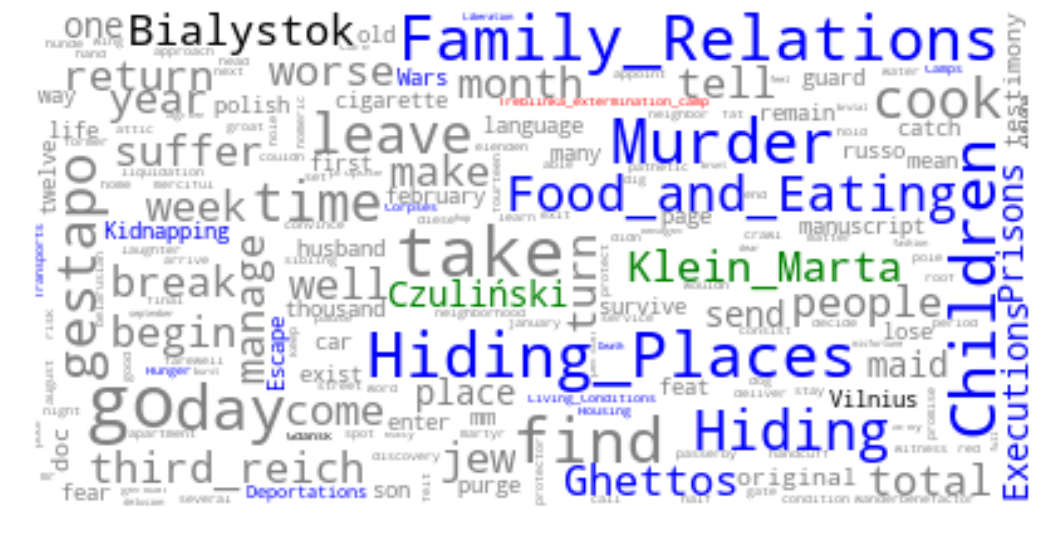

In [127]:
all_persnames = []
all_places = []
all_camps = []
all_ghettos = []
all_terms = []
cleaned_texts_list = []
file_names = []
for dirpath, dirs, files in os.walk("data/data_EN/HJA_TEI_preklady_EN"):
    for file_name in files:
        file_with_dirpath = dirpath + "/" + file_name
        cleaned_texts_list.append(wordcloud_generator(file_with_dirpath, file_name))
        file_names.append(file_name)
for dirpath, dirs, files in os.walk("data/data_EN/JMP_TEI_preklady_EN"):
    for file_name in files:
        file_with_dirpath = dirpath + "/" + file_name
        cleaned_texts_list.append(wordcloud_generator(file_with_dirpath, file_name))
        file_names.append(file_name)
for dirpath, dirs, files in os.walk("data/data_EN/ZIH_TEI_preklady_EN"):
    for file_name in files:
        file_with_dirpath = dirpath + "/" + file_name
        cleaned_texts_list.append(wordcloud_generator(file_with_dirpath, file_name))
        file_names.append(file_name)

In [122]:
cleaned_texts_df = pd.DataFrame(cleaned_texts_list, columns=["word_list", "places", "camps", "ghettos", "persons", "terms"])
cleaned_texts_df["file_names"] = file_names
cleaned_texts_df.set_index("file_names", inplace=True)
cleaned_texts_df.head()

,word_list,places,camps,ghettos,persons,terms
file_names,,,,,,
EHRI-ET-DEGOB1178_EN.xml,"[degob, protocol, keywords, Ghettoisation, Dep...","[(Solotvyno, 3), (Weimar, 1)]","[(Buchenwald, 5), (Auschwitz_II_Birkenau, 5), ...",[],[],"[(People, 6), (Families, 3), (Deportation_Trai..."
EHRI-ET-DEGOB0594_EN.xml,"[degob, protocol, 594, keywords, Anti_Jewish_L...","[(Hungary, 4), (Uzhgorod, 3), (Kamianets_Podil...","[(Bergen_Belsen, 4), (Salzwedel, 3), (Auschwit...",[],"[(Gunzenberger_Fanny, 1)]","[(Food_and_Eating, 10), (Forced_Labour, 5), (S..."
EHRI-ET-DEGOB1459_EN.xml,"[degob, protocol, keywords, Ghettoisation, Dep...","[(Mukacheve, 2), (Horneburg, 2), (Celle, 2), (...","[(Bergen_Belsen, 4), (Weisswasser, 4), (Auschw...",[],"[(Bleier_Berta, 2), (Engelbreckl, 1), (Bleier_...","[(Living_Conditions, 14), (Forced_Labour, 13),..."
EHRI-ET-DEGOB0005_EN.xml,"[degob, protocol, keywordsghettoisationdeporta...","[(Kosice, 3), (Oradea, 2), (Hungary, 1), (Buda...","[(Auschwitz_II_Birkenau, 4), (Dondangen_I, 1)]",[],"[(Gal_Rene, 1), (Klein_Simon, 1), (Polacsek, 1...","[(Forced_Labour, 11), (Women, 8), (Food_and_Ea..."
EHRI-ET-DEGOB1359_EN.xml,"[degob, protocol, keywords, Ghettoisation, Dep...","[(Chepa, 2), (Vynohradiv, 2), (Psie_Pole, 2), ...","[(Auschwitz_II_Birkenau, 4), (Bergen_Belsen, 4...",[],"[(Jarusil_József, 1)]","[(Clothings, 11), (Transports, 10), (Men, 9), ..."


In [123]:
### to connect with a google spread sheet file
sh = gc.open_by_url("https://docs.google.com/spreadsheets/d/1W9TnF_x1v2i8DHgl3L6-A6KmtwGyOHC3CfsiVZtMJtg/edit?usp=sharing")
try: sh.del_worksheet(sh.worksheet("overview_data"))
except: pass
set_with_dataframe(sh.add_worksheet(title="overview_data", rows=1, cols=1), cleaned_texts_df)

In [124]:
### to connect with a google spread sheet file
sh = gc.open_by_url("https://docs.google.com/spreadsheets/d/1W9TnF_x1v2i8DHgl3L6-A6KmtwGyOHC3CfsiVZtMJtg/edit?usp=sharing")

def freq_dist_worksheet(wordlist, worksheet_title):
    freq_dist = nltk.FreqDist(wordlist)
    freq_dist_df = pd.DataFrame(list(freq_dist.items()), columns = ["Word","Frequency"])
    freq_dist_df_sorted = freq_dist_df.sort_values(by="Frequency", ascending=False)
    try: sh.del_worksheet(sh.worksheet(worksheet_title))
    except: pass
    set_with_dataframe(sh.add_worksheet(title=worksheet_title, rows=1, cols=1), freq_dist_df_sorted)

In [125]:
freq_dist_worksheet(all_persnames,"all_persnames")
freq_dist_worksheet(all_places,"all_places")
freq_dist_worksheet(all_camps,"all_camps")
freq_dist_worksheet(all_persnames,"all_ghettos")
freq_dist_worksheet(all_persnames,"all_terms")

# Vectorization and Distance

In [137]:
# raw documents as a list of lists
cleaned_texts_joined_list = cleaned_texts_df["word_list"].tolist()
cleaned_texts_joined_list = [" ".join(element) for element in cleaned_texts_joined_list]

In [142]:
vec = CountVectorizer(min_df = 2)
X = vec.fit_transform(cleaned_texts_joined_list)

vectorization_df = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())
vectorization_df.index = file_names
vectorization_df.head(5)

,06,10,12,15,18,1943,1944,20,30,40,...,yiddish,you,young,younger,youth,za,zionism,zloty,zone,łódź
EHRI-ET-DEGOB1178_EN.xml,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
EHRI-ET-DEGOB0594_EN.xml,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
EHRI-ET-DEGOB1459_EN.xml,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
EHRI-ET-DEGOB0005_EN.xml,0,1,2,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
EHRI-ET-DEGOB1359_EN.xml,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [153]:
### COSINE SIMILARITY
# https://en.wikipedia.org/wiki/Cosine_similarity
# as used here: https://de.dariah.eu/tatom/working_with_text.html#comparing-texts

from sklearn.metrics.pairwise import cosine_similarity
cosine_sim_matrix = cosine_similarity(X.toarray())
dist_cosine = 1 - cosine_similarity(X.toarray())

cosine_sim_df = pd.DataFrame(np.round(cosine_sim_matrix, 5))
cosine_sim_df.columns = file_names
cosine_sim_df.index = file_names

In [150]:
### to connect with a google spread sheet file
sh = gc.open_by_url("https://docs.google.com/spreadsheets/d/1W9TnF_x1v2i8DHgl3L6-A6KmtwGyOHC3CfsiVZtMJtg/edit?usp=sharing")

set_with_dataframe(sh.add_worksheet(title="cosine_similarity", rows=1, cols=1), cosine_sim_df)

In [151]:
### to transform the distances into a n-dimensional space 
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
# to have the plot big enough, we will modify default size of all generated plots
# (original is 6 to 4 inches)
plt.rcParams['figure.figsize'] = (18.0, 12.0)

In [154]:
# we need to transform the indovidual distances into a 2-dimensional space
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(dist_cosine)
xs, ys = pos[:, 0], pos[:, 1]

In [156]:
file_names

['EHRI-ET-DEGOB1178_EN.xml',
 'EHRI-ET-DEGOB0594_EN.xml',
 'EHRI-ET-DEGOB1459_EN.xml',
 'EHRI-ET-DEGOB0005_EN.xml',
 'EHRI-ET-DEGOB1359_EN.xml',
 'EHRI-ET-DEGOB0701_EN.xml',
 'EHRI-ET-DEGOB0099_EN.xml',
 'EHRI-ET-DEGOB1640_EN.xml',
 'EHRI-ET-DEGOB0884_EN.xml',
 'EHRI-ET-DEGOB0748_EN.xml',
 'EHRI-ET-DEGOB2719_EN.xml',
 'EHRI-ET-DEGOB0090_EN.xml',
 'EHRI-ET-DEGOB0651_EN.xml',
 'EHRI-ET-DEGOB0086_EN.xml',
 'EHRI-ET-DEGOB2830_EN.xml',
 'EHRI-ET-JMP011_EN.xml',
 'EHRI-ET-JMP003_EN.xml',
 'EHRI-ET-JMP001_EN.xml',
 'EHRI-ET-JMP013_EN.xml',
 'EHRI-ET-JMP017_EN.xml',
 'EHRI-ET-JMP009_EN.xml',
 'EHRI-ET-JMP005_EN.xml',
 'EHRI-ET-JMP019_EN.xml',
 'EHRI-ET-JMP007_EN.xml',
 'EHRI-ET-JMP015_EN.xml',
 'EHRI-ET-JMP010_EN.xml',
 'EHRI-ET-JMP002_EN.xml',
 'EHRI-ET-JMP012_EN.xml',
 'EHRI-ET-JMP008_EN.xml',
 'EHRI-ET-JMP016_EN.xml',
 'EHRI-ET-JMP004_EN.xml',
 'EHRI-ET-JMP020_EN.xml',
 'EHRI-ET-JMP006_EN.xml',
 'EHRI-ET-JMP018_EN.xml',
 'EHRI-ET-JMP014_EN.xml',
 'EHRI-ET-ZIH3010965_EN.xml',
 'EHRI-ET-ZIH30

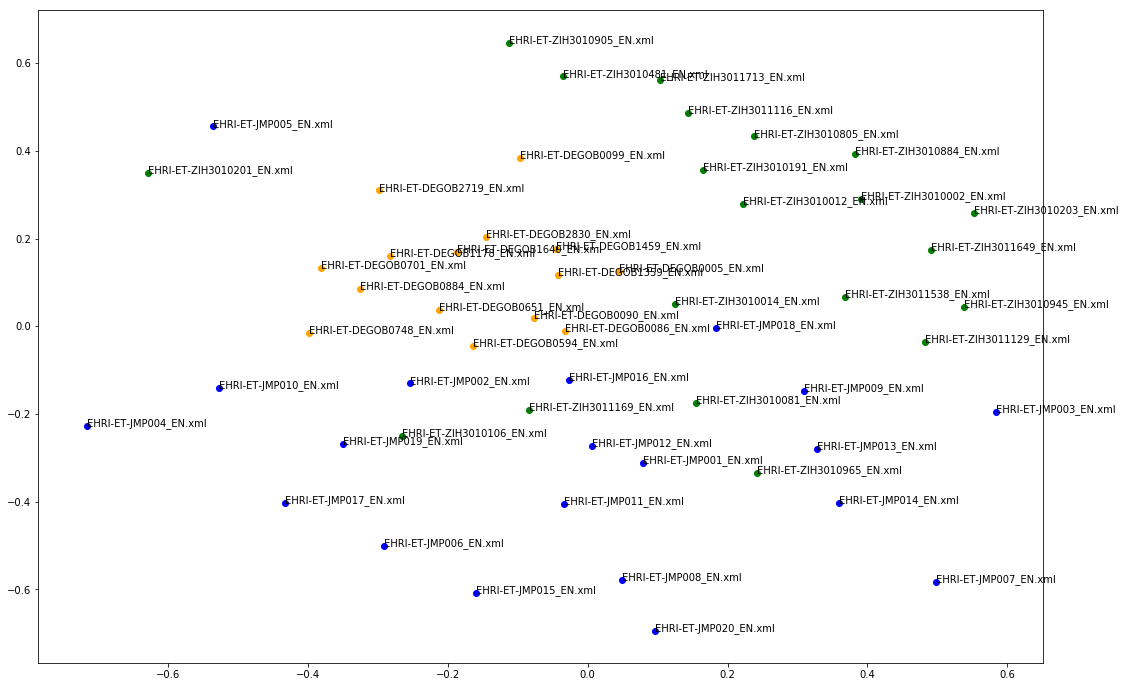

In [159]:
# now we can plot the distances transformed via the mds function as a scatter plot
for x, y, name in zip(xs, ys, file_names):
    if "DEGOB" in name: 
        color = "orange"
    if "JMP" in name: 
        color = "blue"   
    if "ZIH" in name: 
        color = "green"
    plt.scatter(x, y, c=color)
    plt.text(x, y, name)
plt.savefig("images/distances_2d.png")
plt.savefig("images/distances_2d_2.0.png")
plt.show()

In [158]:
plt.savefig("images/distances_2d_2.0.png")

<Figure size 1296x864 with 0 Axes>